In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import neurokit2 as nk
from heartkit.defines import HeartTask, HeartSegment
from heartkit.datasets import IcentiaDataset, LudbDataset, SyntheticDataset

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass


In [2]:
def plot_segmentations(data, labels=None, preds=None, fig=None, ax=None):
    color_map = {HeartSegment.normal: 'lightgray', HeartSegment.pwave: 'purple', HeartSegment.qrs: 'red', HeartSegment.twave: 'green'}

    t = np.arange(0, data.shape[0])
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.plot(t, data)
    if preds is not None:
        pred_bnds = np.where(np.abs(np.diff(preds)) > 0)[0]
        pred_bnds = np.concatenate(([0], pred_bnds, [len(preds)-1]))
        for i in range(pred_bnds.shape[0]-1):   
            c = color_map.get(preds[pred_bnds[i]+1], 'black')
            ax.plot(t[pred_bnds[i]:pred_bnds[i+1]], data[pred_bnds[i]:pred_bnds[i+1]], color=c)
    if labels is not None:
        pass
    return fig, ax


In [7]:
ds_path = "../datasets"
frame_size = 624
frame_overlap = 312
frame_keep = frame_size - frame_overlap
patient = 4


In [8]:
with tf.device('/CPU:0'):
    ds_ludb = LudbDataset(
        ds_path=ds_path,
        task=HeartTask.segmentation,
        frame_size=frame_size,
        target_rate=500,
    )

    ds_sydb = SyntheticDataset(
        ds_path=ds_path,
        task=HeartTask.segmentation,
        frame_size=frame_size, 
        num_pts=100,
        target_rate=500,
    )

    ds_icdb = IcentiaDataset(
        ds_path=ds_path,
        task=HeartTask.beat,
        frame_size=frame_size
    )

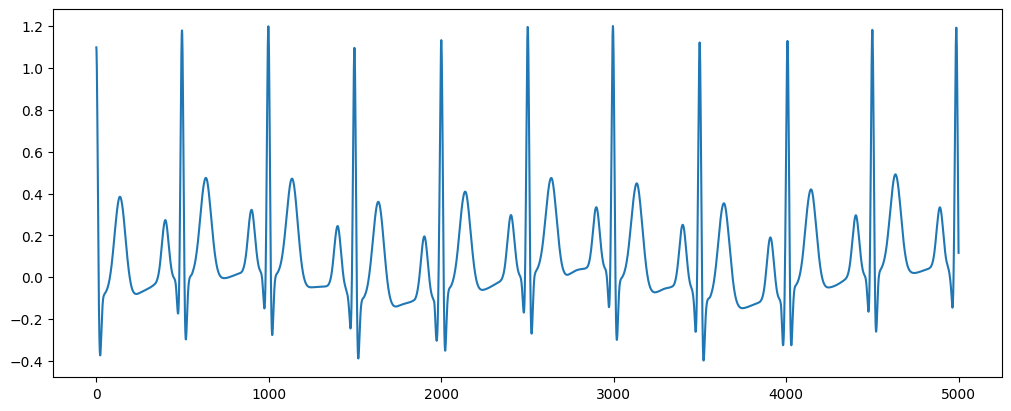

In [9]:
ecg = nk.ecg_simulate(duration=10, heart_rate=60, sampling_rate=500)
fig, ax = plot_segmentations(data=ecg, labels=None, preds=None)
fig.show()

* Use LUDB, QT, and Synthetic to train 
* Need to resample to 500 Hz (use all leads)
* Apply augmentations: inject noise, artifacts
* Apply filter, baseline wander removal, and normalize signal 

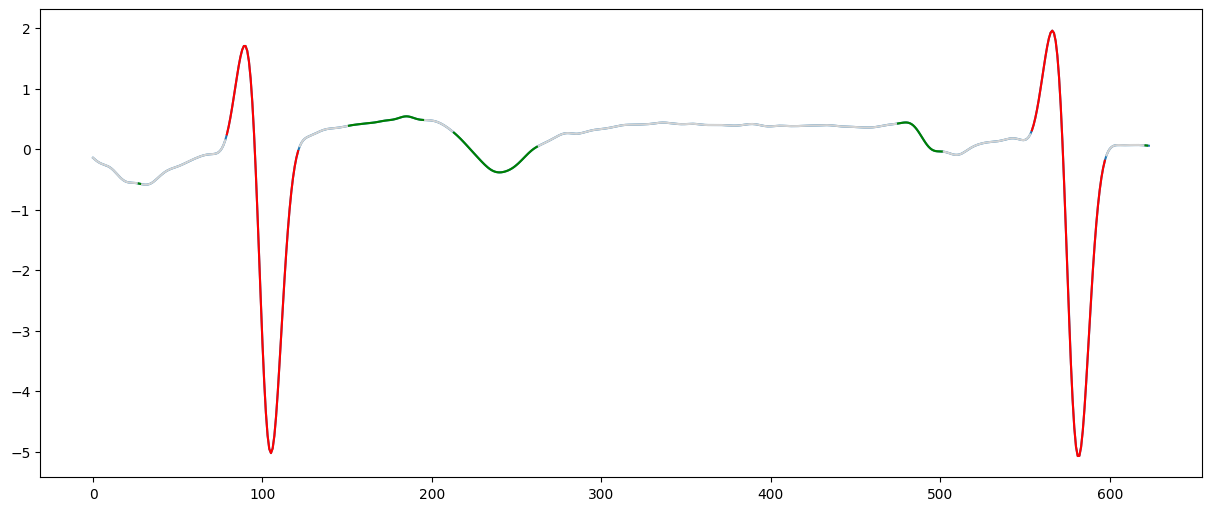

: 

In [10]:
%matplotlib inline
import time
from IPython import display

with tf.device('/CPU:0'):
    model = tf.keras.models.load_model("../results/segmentation/model.tf")

    test_ds = ds_ludb.load_test_dataset(
        test_patients=0.2,
        test_pt_samples=5,
        repeat=False
    )

    fig, ax = plt.subplots(figsize=(12, 5), layout="constrained")
    for x, y in test_ds.as_numpy_iterator():
        y_pred = model.predict(x.reshape((1, 1, -1, 1))).squeeze()
        y_pred = np.argmax(y_pred, axis=1).squeeze()
        y_true = np.argmax(y.squeeze(), axis=1).squeeze()

        plot_segmentations(data=x.squeeze(), labels=None, preds=y_pred, fig=fig, ax=ax)
        display.clear_output(wait=True)
        display.display(fig)    
        time.sleep(2.0)  # input("Press Enter to continue...")
        ax.cla()
    plt.close(fig)


In [3]:
h5 = h5py.File("../datasets/icentia11k/p00001.h5", "r")

In [4]:
blabels = h5["p00001"]["s01"]["blabels"]

In [5]:
blabel_diffs = np.diff(blabels, axis=0)

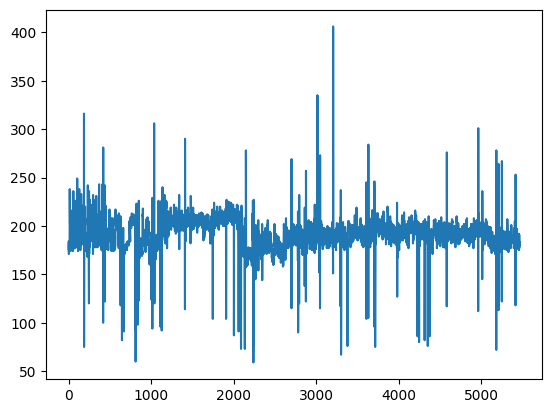

In [6]:
plt.plot(np.arange(blabel_diffs.shape[0]), blabel_diffs[:,0])

In [12]:
idxs = np.where((blabels[:-1,1] == 1) & (blabel_diffs[:,1] == 0))[0]

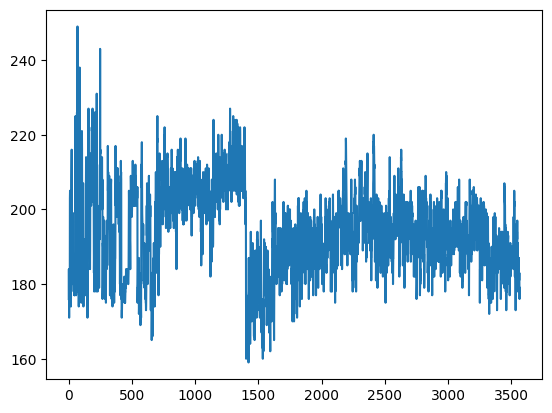

In [15]:
plt.plot(np.arange(idxs.shape[0]), blabel_diffs[idxs,0])

In [16]:
blabel_diffs[idxs,0].mean()

194.28867713004485

In [17]:
blabel_diffs[idxs,0].std()

11.29926510760714

In [22]:
np.where(blabels[:,1] == 2)[0]

array([2860])

In [24]:
blabels[2860-1:2860+2]

array([[548999,      1],
       [549137,      2],
       [549356,      1]], dtype=int32)

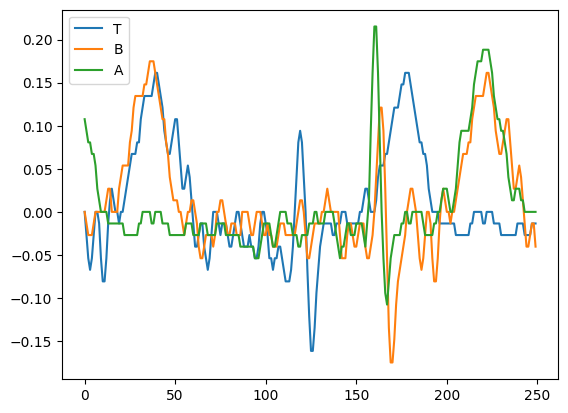

In [84]:
b_idx = 2860
d_idx = blabels[b_idx, 0]
frame_start = d_idx - 125
frame_end = frame_start + 250
x = np.arange(250)
# Target beat
plt.plot(x, h5["p00001"]["s01"]["data"][frame_start:frame_end], label='T')
# Previous beat
plt.plot(x, h5["p00001"]["s01"]["data"][frame_start-183:frame_end-183], label='B')
plt.plot(x, h5["p00001"]["s01"]["data"][frame_start+183:frame_end+183], label='A')
plt.legend()


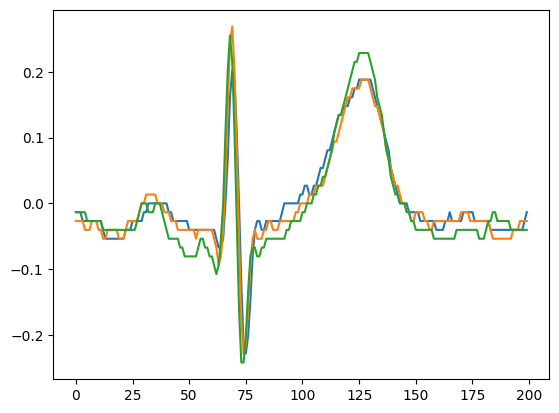

In [78]:
b_idx = 2260
d_idx = blabels[b_idx, 0]
frame_start = d_idx - 75
frame_end = frame_start + 200
x = np.arange(200)
# Target beat
plt.plot(x, h5["p00001"]["s01"]["data"][frame_start:frame_end])
# Previous beat
plt.plot(x, h5["p00001"]["s01"]["data"][frame_start-171:frame_end-171])
plt.plot(x, h5["p00001"]["s01"]["data"][frame_start+171:frame_end+171])


In [27]:
h5["p00001"]["s01"]["data"].shape

(1048577, 1)

In [48]:
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d


In [57]:
rr_fn = interp1d(blabels[idxs, 0], blabel_diffs[idxs, 0], kind="nearest", fill_value="extrapolate")

In [74]:
N = 20*250
x = np.arange(0, h5["p00001"]["s01"]["data"].shape[0])
avg_rrs = rr_fn(x)
avg_rrs = uniform_filter1d(avg_rrs, size=N)

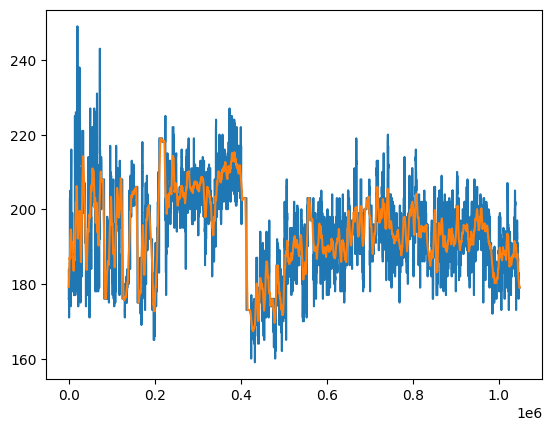

In [75]:
plt.plot(x, rr_fn(x))
plt.plot(x, avg_rrs)

In [80]:
avg_rrs[d_idx]

183.3696

In [85]:
blabels[b_idx, :]

array([549137,      2], dtype=int32)